<a href="https://colab.research.google.com/github/de-eplearn/dLearn/blob/master/tensorflow_probability/Probabilistic_Layers_Non_Linear_Regression_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2019 The TensorFlow Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [0]:
#@title Licensed under the Apache License, Version 2.0 (the "License"); { display-mode: "form" }
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# TFP Probabilistic Layers: Regression

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/Probabilistic_Layers_Regression.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/Probabilistic_Layers_Regression.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

In this example we show how to fit regression models using TFP's "probabilistic layers."

### Dependencies & Prerequisites


In [0]:
#@title Install { display-mode: "form" }
TF_Installation = 'TF2 Nightly (GPU)' #@param ['TF2 Nightly (GPU)', 'TF2 Stable (GPU)', 'TF1 Nightly (GPU)', 'TF1 Stable (GPU)','System']

if TF_Installation == 'TF2 Nightly (GPU)':
  !pip install -q --upgrade tf-nightly-gpu-2.0-preview
  print('Installation of `tf-nightly-gpu-2.0-preview` complete.')
elif TF_Installation == 'TF2 Stable (GPU)':
  !pip install -q --upgrade tensorflow-gpu==2.0.0-alpha0
  print('Installation of `tensorflow-gpu==2.0.0-alpha0` complete.')
elif TF_Installation == 'TF1 Nightly (GPU)':
  !pip install -q --upgrade tf-nightly-gpu
  print('Installation of `tf-nightly-gpu` complete.')
elif TF_Installation == 'TF1 Stable (GPU)':
  !pip install -q --upgrade tensorflow-gpu
  print('Installation of `tensorflow-gpu` complete.')
elif TF_Installation == 'System':
  pass
else:
  raise ValueError('Selection Error: Please select a valid '
                   'installation option.')

Installation of `tf-nightly-gpu-2.0-preview` complete.


In [0]:
#@title Install { display-mode: "form" }
TFP_Installation = "Nightly" #@param ["Nightly", "Stable", "System"]

if TFP_Installation == "Nightly":
  !pip install -q tfp-nightly
  print("Installation of `tfp-nightly` complete.")
elif TFP_Installation == "Stable":
  !pip install -q --upgrade tensorflow-probability
  print("Installation of `tensorflow-probability` complete.")
elif TFP_Installation == "System":
  pass
else:
  raise ValueError("Selection Error: Please select a valid "
                   "installation option.")

Installation of `tfp-nightly` complete.


In [0]:
tfp.__version__

'0.7.0-dev20190414'

In [0]:
!pip install -q --upgrade seaborn

In [0]:
#@title Import { display-mode: "form" }

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from pprint import pprint
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import tensorflow as tf
from tensorflow.python import tf2
if not tf2.enabled():
  import tensorflow.compat.v2 as tf
  tf.enable_v2_behavior()
  assert tf2.enabled()

import tensorflow_probability as tfp

from sklearn.datasets.samples_generator import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from pathlib import Path

sns.reset_defaults()
#sns.set_style('whitegrid')
#sns.set_context('talk')
sns.set_context(context='talk',font_scale=0.7)

%matplotlib inline

tfd = tfp.distributions

### Make things Fast!

Before we dive in, let's make sure we're using a GPU for this demo.  

To do this, select "Runtime" -> "Change runtime type" -> "Hardware accelerator" -> "GPU".

The following snippet will verify that we have access to a GPU.

In [0]:
if tf.test.gpu_device_name() != '/device:GPU:0':
  print('WARNING: GPU device not found.')
else:
  print('SUCCESS: Found GPU: {}'.format(tf.test.gpu_device_name()))

SUCCESS: Found GPU: /device:GPU:0


Note: if for some reason you cannot access a GPU, this colab will still work. (Training will just take longer.)

## Motivation

Wouldn't it be great if we could use TFP to specify a probabilistic model then simply minimize the negative log-likelihood, i.e.,

In [0]:
negloglik = lambda y, rv_y: -rv_y.log_prob(y)

Well not only is it possible, but this colab shows how! (In context of linear regression problems.)

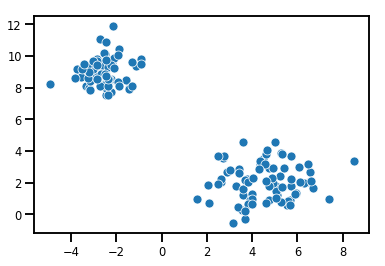

In [0]:
#@title Synthesize dataset.
np.random.seed(42)

def load_dataset(n=150, n_tst=150):
  data, classes = make_blobs(n_samples=n+n_tst, centers=2, n_features=2, 
                             cluster_std=(0.75, 1.25))
  x = data[:, 0].reshape((-1, 1))
  y = data[:, 1].reshape((-1, 1))
  x_range = [x.min(), x.max()]
  x, x_tst, y, y_tst = train_test_split(x, y, test_size=n_tst/(n+n_tst))
  return y, x, y_tst, x_tst, x_range

y, x, y_tst, x_tst, x_range = load_dataset()
sns.scatterplot(x[:, 0], y[:, 0])
plt.show()

### Case 1: No Uncertainty

In [0]:
# Build model.
model = tf.keras.Sequential([
  tf.keras.layers.Dense(1, activation=tf.nn.sigmoid),
  tf.keras.layers.Dense(1),
  tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t, scale=1)),
])

# Do inference.
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=negloglik)
model.fit(x, y, epochs=1000, verbose=False);

# Profit.
[print(np.squeeze(w.numpy())) for w in model.weights];
yhat = model(x_tst)
assert isinstance(yhat, tfd.Distribution)

-2.882992
0.8606771
6.9773264
2.0388005


In [0]:
def plot_validation(mod, n_samples=20, n_points=25):
  x_vals = np.linspace(x_range[0], x_range[1], n_points).reshape((-1, 1))
  preds = [mod(x_vals) for _ in range(n_samples)]
  mean = np.array([pred.mean() for pred in preds]).mean(axis=0)
  stddev = np.array([pred.stddev()**2 + (pred.mean() - mean)**2 
                     for pred in preds])
  stddev = np.sqrt(stddev.mean(axis=0))
  mean = np.squeeze(mean)
  stddev = np.squeeze(stddev)
  sns.scatterplot(np.squeeze(x), np.squeeze(y), color='g', label='observed')
  sns.lineplot(np.squeeze(x_vals), mean, color='b', linewidth=4, label='mean')
  sns.lineplot(np.squeeze(x_vals), mean + 2 * stddev, color='r', linewidth=2, label=r'mean + 2 stddev')
  sns.lineplot(np.squeeze(x_vals), mean - 2 * stddev, color='r', linewidth=2, label=r'mean - 2 stddev')
  plt.legend(loc='center left', fancybox=True, framealpha=0., bbox_to_anchor=(1.05, 0.5))
  plt.show()
  sns.lineplot(np.squeeze(x_vals), stddev, color='r', label='stddev')
  plt.legend(loc='center left', fancybox=True, framealpha=0., bbox_to_anchor=(1.05, 0.5))
  plt.show()

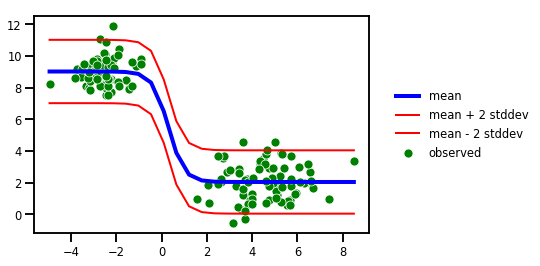

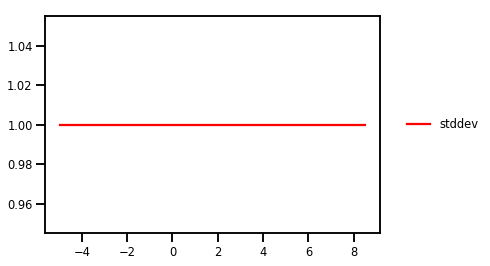

In [0]:
#@title Figure 1: No Uncertainty
plot_validation(model)

### Case 2: Aleatoric Uncertainty

In [0]:
# Build model.
model = tf.keras.Sequential([
  tf.keras.layers.Dense(1, activation=tf.nn.sigmoid),
  tf.keras.layers.Dense(1 + 1),
  tfp.layers.DistributionLambda(
      lambda t: tfd.Normal(loc=t[..., :1],
                           scale=1e-3 + tf.math.softplus(0.05 * t[...,1:]))),
])

# Do inference.
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=negloglik)
model.fit(x, y, epochs=1000, verbose=False);

# Profit.
[print(np.squeeze(w.numpy())) for w in model.weights];
yhat = model(x_tst)
assert isinstance(yhat, tfd.Distribution)

-3.5415356
0.9694455
[6.971902  2.2873924]
[2.0448496 5.7295475]


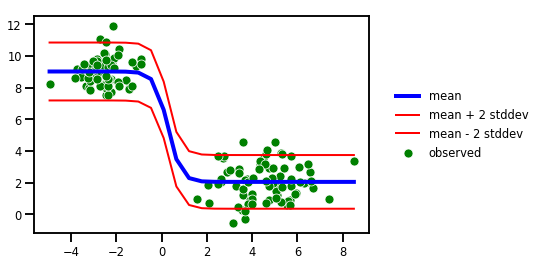

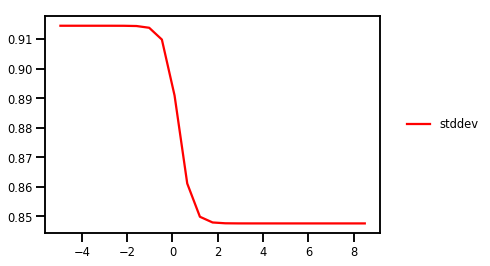

In [0]:
#@title Figure 2: Aleatoric Uncertainty
plot_validation(model)

### Case 3: Epistemic Uncertainty

In [0]:
# Specify the surrogate posterior over `keras.layers.Dense` `kernel` and `bias`.
def posterior_mean_field(kernel_size, bias_size=0, dtype=None):
  n = kernel_size + bias_size
  c = np.log(np.expm1(1.))
  return tf.keras.Sequential([
      tfp.layers.VariableLayer(2 * n, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t[..., :n],
                     scale=1e-5 + tf.nn.softplus(c + t[..., n:])),
          reinterpreted_batch_ndims=1)),
  ])

In [0]:
# Specify the surrogate posterior over `keras.layers.Dense` `kernel` and `bias`.
def prior_trainable(kernel_size, bias_size=0, dtype=None):
  n = kernel_size + bias_size
  return tf.keras.Sequential([
      tfp.layers.VariableLayer(n, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t, scale=1),
          reinterpreted_batch_ndims=1)),
  ])

In [0]:
# Build model.
model = tf.keras.Sequential([
  tfp.layers.DenseVariational(1, posterior_mean_field, prior_trainable, 
                              activation=tf.nn.sigmoid),
  tfp.layers.DenseVariational(1, posterior_mean_field, prior_trainable),
  tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t, scale=1)),
])

# Do inference.
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=negloglik)
model.fit(x, y, epochs=1000, verbose=False);

# Profit.
[print(np.squeeze(w.numpy())) for w in model.weights];
yhat = model(x_tst)
assert isinstance(yhat, tfd.Distribution)

[-3.5695024   0.65241694 -0.09180503  0.05384891]
[-3.550108    0.69934905]
[ 6.991989    2.0374646  -0.29366562 -0.41085854]
[6.8549156 2.1405208]


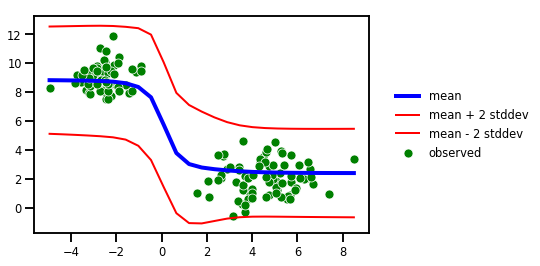

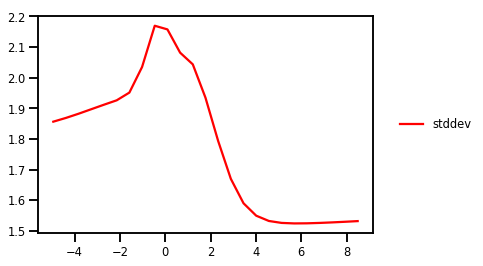

In [0]:
#@title Figure 3: Epistemic Uncertainty
plot_validation(model, n_samples=20)

### Case 4: Aleatoric & Epistemic Uncertainty

In [0]:
# Build model.
model = tf.keras.Sequential([
  tfp.layers.DenseVariational(1, posterior_mean_field, prior_trainable, 
                              activation=tf.nn.sigmoid),
  tfp.layers.DenseVariational(1 + 1, posterior_mean_field, prior_trainable),
  tfp.layers.DistributionLambda(
      lambda t: tfd.Normal(loc=t[..., :1],
                           scale=1e-3 + tf.math.softplus(0.01 * t[...,1:]))),
])

# Do inference.
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=negloglik)
model.fit(x, y, epochs=1000, verbose=False);

# Profit.
[print(np.squeeze(w.numpy())) for w in model.weights];
yhat = model(x_tst)
assert isinstance(yhat, tfd.Distribution)

[-3.826748    0.8981941  -0.04491479 -0.04312763]
[-3.729905   0.7859884]
[ 6.995529    0.7293834   2.0390182   1.1427375  -0.58716893  0.11661873
 -0.72052455 -0.16807057]
[7.0027113 0.6339093 2.0093    1.2158384]


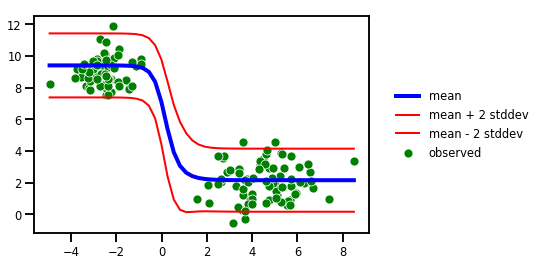

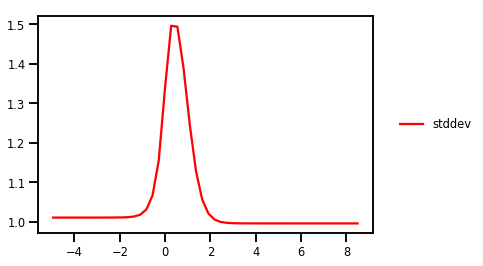

In [0]:
#@title Figure 4: Both Aleatoric & Epistemic Uncertainty
plot_validation(model, n_points=50)